# SageMaker Studioで深層学習モデルの学習を加速・コスト最適化する

データ量が増えてきて、深層学習モデルの学習に時間がかかりすぎていませんか？

このノートブックでは、深層学習モデルの学習にかかる時間とコストを最適化する手順を、SageMaker Data Parallelism LibraryとSageMaker Debuggerを使いながらご紹介します。

SageMaker Data Parallelism Libraryは、AWS上での分散学習実行に最適化されているため、HorovodやPyTorch DDPなどの他の分散学習フレームワークに比べて並列化効率がより高いことが証明されています。

今回は、例としてMask RCNNモデルにCOCO2017データセットをゼロから学習するのにかかる時間とコストのトレードオフを見ていきます。

なお、このノートブックはSageMaker Studio上のPython 3 (PyTorch 1.6 Python 3.6 GPU Optimized)環境で動作確認をしております。

他のフレームワークやモデルでの分散学習のスクリプトは[こちら](https://github.com/HerringForks/DeepLearningExamples)を参照してください。

## 学習時間と課金額のトレードオフでトータルコスト最適化を考える

SageMaker上で分散学習を実施することで、時間とお金のトレードオフがコントロールできるようになります。

インスタンスの使用料金をPドル/時、学習にかかる時間をT時間、並列化効率(インスタンス x個で学習時間がx倍にどれくらい近くなるか)をS%として、１個のインスタンス（またはGPU）からN個のインスタンス（またはGPU）に分散学習する場合を考えてみましょう。

学習にかかる時間はT時間から(T/N)/S時間に減り、インスタンス使用料金はT * Pドルから(T/N)/S * P * N = T/S * Pドルへ（S = 1、すなわち並列化効率100%とならない限りは）増加します。並列化効率が十分高ければ、大幅な学習時間短縮を少ない金額の増加で買うことができる、というわけです。コストを時間とお金と捉えると、分散学習が１つのコスト最適化のツールとなり、かつ並列化効率がそのトレードオフを決定する重要な要因であることがご理解いただけると思います。

例えば、p3.2xlargeインスタンスで24時間学習に時間を取られている場合、8つのインスタンスに90%の並列化効率で分散学習が実現できれば、時間とコストは以下のように変化します。

分散学習なしでは24 * 3.825 = 91.8ドル（us-west-2リージョンで[SageMaker Savings Plan](https://aws.amazon.com/about-aws/whats-new/2021/04/amazon-sagemaker-announces-a-price-reduction-in-instances-and-sagemaker-savings-plan/)を使用しない場合）のお金と24時間という時間がかかります。

上記の条件で分散学習をすると、24/0.9 * 3.825 = 102ドルのお金と24/8/0.9 = 3.33時間という時間になります。

約11%の金額増加で約86%も学習時間を短縮できるのです。どちらのトータルコストが良いかどうかは、ビジネス上で深層学習のモデル学習時間短縮がどれくらい重要かによります。しかし、モデルを何度も再学習する必要に迫られる中で、これからデータ量が増えていくことが予測されるならば、分散学習というツールを１つの選択肢として持っておくのは悪くないかもしれません。

※この例だと、p3.2xlargeインスタンスを８個のインスタンスにスケールアウトする他に、8個のGPUをもつp3.16xlargeインスタンスを1個使うという方法もあります。これも同様に今回紹介する分散学習の手法としては変わりません。

### 分散学習すべきかを判断するには並列化効率が鍵

分散学習をする上で、鍵となるのは並列化効率です。どのくらいの並列化効率があれば、

実際に現在の深層学習モデルの学習にかかっている時間とインスタンスの料金をもとに、トータルコストをシミュレーションしてみましょう。

SageMakerインスタンスの料金は[こちら](https://aws.amazon.com/jp/sagemaker/pricing/?nc1=h_ls)を参照してください。

これで目指すべき並列化効率が求められます。

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# 学習に何時間かかっているか
TRAINING_TIME = 24

# インスタンスに時間あたり何ドルかかっているか
INSTANCE_PRICE = 3.825

# 何個インスタンスを使うか
NUM_INSTANCES = 8

# １時間学習が長くなることによる機会費用 (トータルコストをドルで統一するため)
TIME_VALUE = 3

In [65]:
def before_total_cost(T, P, weight):
    # トータルコスト = お金 + 時間
    return T * P + T * weight

def after_total_cost(T, P, N, weight, S):
    return T/S * P + T/N/S * weight

In [93]:
def plot_simulation(T, P, N, weight):
    '''
    横軸: 並列化効率
    縦軸: トータルコスト（ドル）
    分散学習をする場合、最低でもどのくらいの並列化効率が必要かをグラフから目安をつける
    '''
    # 並列化効率を10% ~ 100%までシミュレーション
    scaling_efficiencies = list(np.arange(0.10, 1.01, 0.01))
    
    before = []
    after = []
    for S in scaling_efficiencies:
        before_cost = before_total_cost(TRAINING_TIME, INSTANCE_PRICE, TIME_VALUE)
        before.append(before_cost)
        after_cost = after_total_cost(TRAINING_TIME, INSTANCE_PRICE, NUM_INSTANCES, TIME_VALUE, S)
        after.append(after_cost)
        if round(S*100) % 10 == 0:
            is_cost_lower = after_cost < before_cost
            cost_diff = abs((after_cost - before_cost) / before_cost) * 100
            up = "上がる"
            down = "下がる"
            print(f"並列化効率 {S*100:.1f}%でトータルコストは{cost_diff:.3f}% {down if is_cost_lower else up}")
    print()
    plt.plot(scaling_efficiencies, before, label="before")
    plt.plot(scaling_efficiencies, after, label="after")
    plt.legend()

並列化効率 10.0%でトータルコストは515.385% 上がる
並列化効率 20.0%でトータルコストは207.692% 上がる
並列化効率 30.0%でトータルコストは105.128% 上がる
並列化効率 40.0%でトータルコストは53.846% 上がる
並列化効率 50.0%でトータルコストは23.077% 上がる
並列化効率 60.0%でトータルコストは2.564% 上がる
並列化効率 70.0%でトータルコストは12.088% 下がる
並列化効率 80.0%でトータルコストは23.077% 下がる
並列化効率 90.0%でトータルコストは31.624% 下がる
並列化効率 100.0%でトータルコストは38.462% 下がる



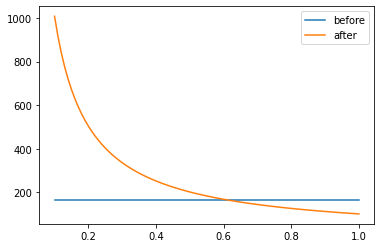

In [94]:
plot_simulation(TRAINING_TIME, INSTANCE_PRICE, NUM_INSTANCES, TIME_VALUE)

この例だと、1時間学習時間が長くなることで平均３ドルほどの機会費用が発生すると仮定してみると、最低でも並列化効率が60%トータルコストは下がらないことがわかります。逆に、

## 0. 準備

IAMやインスタンスの緩和申請

## 1. データセットのダウンロード

COCO2017のデータセットをS3へダウンロードします

## 2. インスタンス１つで学習してみる

インスタンス１つで学習を回すのにかかる時間とスクショ

### 2.1 SageMaker Debuggerでプロファイリングする

## 3. 分散学習用のコードを追加する

どこの行に何を追加するのか

また、それはなぜか


## 4. 複数インスタンスで分散学習

とりあえずスケールアウトする場合

### 4.1 プロファイリングしてボトルネックを探す

ここでIOとコンピュートにボトルネック発見

## 5. FSx for Lustreを使ってIOを加速する

## 6. 複数GPU、１インスタンスで分散学習

コミュニケーションがより速くなっている